# *TASK3: PRETENS - SUBTASK2*


This notebook is a starting code for the Task3-Subtask2 for the PreTens in SemEval. In this notebook, you will find an end2end pipelne showing how the data is used for a baseline evaluation. 
The script includes a simple regression model using n-grams as features. The data for subtask-2 is divided into two-folds. For convinience, we provided the folds in the SemEval task git repository.

The participants can use the given fold to re-create the below experiment. The participant are free to merge the whole data (i.e, folds) and to customised split.

This task include 3 languages: English (En), French (Fr) and Italian (It)


In [ ]:
# -*- coding: utf-8 -*- #
"""*********************************************************************************************"""
#   FileName     [ SemEval-Task3-Baseline-subtask2.ipynb ]
#   Synopsis     [ Scripts for re-creating baselines using N-grams features
#                  with linear regressor and validated using cross-validation   ]
#   Author       [ Shammur A Chowdhury ]

"""*********************************************************************************************"""


Cloning the git repository, to get data for Task3:subtask-2


In [ ]:
##### Data Reader -- English/French/Italian
!git clone https://github.com/shammur/SemEval2022Task3.git
%cd ./SemEval2022Task3/
#data/train/train_subtask-2/
!ls

Cloning into 'SemEval2022Task3'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 227 (delta 96), reused 87 (delta 29), pack-reused 0
Receiving objects: 100% (227/227), 626.45 KiB | 14.24 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/SemEval2022Task3
baseline  data	LICENSE  pretens_logo.png  README.md  Task-timeline


Setting up the environment for the task

In [ ]:
import os, sys, time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.svm import SVR
from scipy import stats
from collections import defaultdict
import numpy as np
import pandas as pd
import statistics

from baseline.utils import get_train_dev, compute_metrics_task2, process_eval_jsons_task2

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



Task Path setups

In [ ]:
##Task Paths and Setups
task_folder="./data/train/train_subtask-2/"
languages=['En', 'Fr', 'It']
fold_sets=['fold_0', 'fold_1']

Function used to run the training and evaluation loop.
Below we are selecting one fold as test and the rest is merged (in case of more than 2 folds) to make training data
 

In [ ]:
def run_train_and_evaluation_folds(fold_tables, ngram=3):
  selected_folds=0
  eval_jsons=[]

  
  while selected_folds <len(fold_tables):

    print('Running Folds # ....' ,selected_folds)
    
    ###Creating train test splits ...
    train, dev=get_train_dev(selected_folds,fold_tables)
    
    
    #converting to lower case
    # train['Sentence'] = train.Sentence.map(lambda x: x.lower()) 
    # dev['Sentence'] = dev.Sentence.map(lambda x: x.lower()) 

    #Removing the punctuation
    # train['Sentence'] = train.Sentence.str.replace('[^\w\s]', '')  
    # dev['Sentence'] = dev.Sentence.str.replace('[^\w\s]', '')  

    #Get text and lables
    train_texts=(train['Sentence'])
    y_train=np.array(train['Score'])

    
    dev_texts=(dev['Sentence'])
    test_true_y=np.array(dev['Score'])   

    #Creating ngram features
    tfidf_vectorizer = TfidfVectorizer(encoding='utf-8', lowercase=True, ngram_range=(1, ngram), norm='l1',
                                           use_idf=True, max_df=0.95, min_df=3, max_features=1000) 

    train_x_feat = tfidf_vectorizer.fit_transform(train_texts)
    
    
    #Training Linear Model
    regresson =SVR(C=1.0, epsilon=0.2).fit(train_x_feat, y_train)
    
    ##Testing:
    test_x_feat = tfidf_vectorizer.transform(dev_texts)
    test_pred_y = regresson.predict(test_x_feat)
    
    ##Evaluation per fold
    eval_jsons.append(compute_metrics_task2(test_pred_y,test_true_y))
    selected_folds+=1
    
  return eval_jsons

The main task loop for all the involed languages



In [ ]:
###Running the SubTask-2 for mentioned languages:

for lang in languages:
  taskid=lang+'-Subtask2-'
  file_path=task_folder+lang.lower()
  print('Running for Task2 in Folder:', file_path)
  
  fold_tables = [pd.read_csv(os.path.join(file_path, taskid+s + '.tsv'), sep="\t") for s in fold_sets]
  print("Data Sample for Language: ", lang)
  print(fold_tables[0].head()) 

  en_eval_jsons=[]
  en_eval_jsons.extend(run_train_and_evaluation_folds(fold_tables, ngram=3))
  header_row = ['fold 0', 'fold 1', 'average']
  df, rh= process_eval_jsons_task2(en_eval_jsons)
  df.insert(loc=0, column='#', value=header_row)
  print('Printing Results for Language: ', lang)
  print(df.to_markdown()+"\n") 


Running for Task2 in Folder: ./data/train/train_subtask-2/en
Data Sample for Language:  En
    ID                                     Sentence  Score
0   34               I like cats, but not sparrows.   4.77
1  256  I like caviar, an interesting type of veal.   1.83
2  118              I like turkey, but not oysters.   5.42
3  363               I like crabs, and chicken too.   5.75
4  307                  I like oaks, and trees too.   4.00
Running Folds # .... 0
Running Folds # .... 1
Printing Results for Language:  En
|    | #       | mse                | rmse               | rho                 |
|---:|:--------|:-------------------|:-------------------|:--------------------|
|  0 | fold 0  | 1.6337913416112968 | 1.2781984750465387 | 0.5534840512201449  |
|  1 | fold 1  | 2.1575458226401176 | 1.4688586802821153 | 0.49726518942046616 |
|  2 | average | 1.896(±0.37)       | 1.374(±0.13)       | 0.525(±0.04)        |

Running for Task2 in Folder: ./data/train/train_subtask-2/fr
Data Sa

Please below find the official cross-validation baseline for the tasks: 
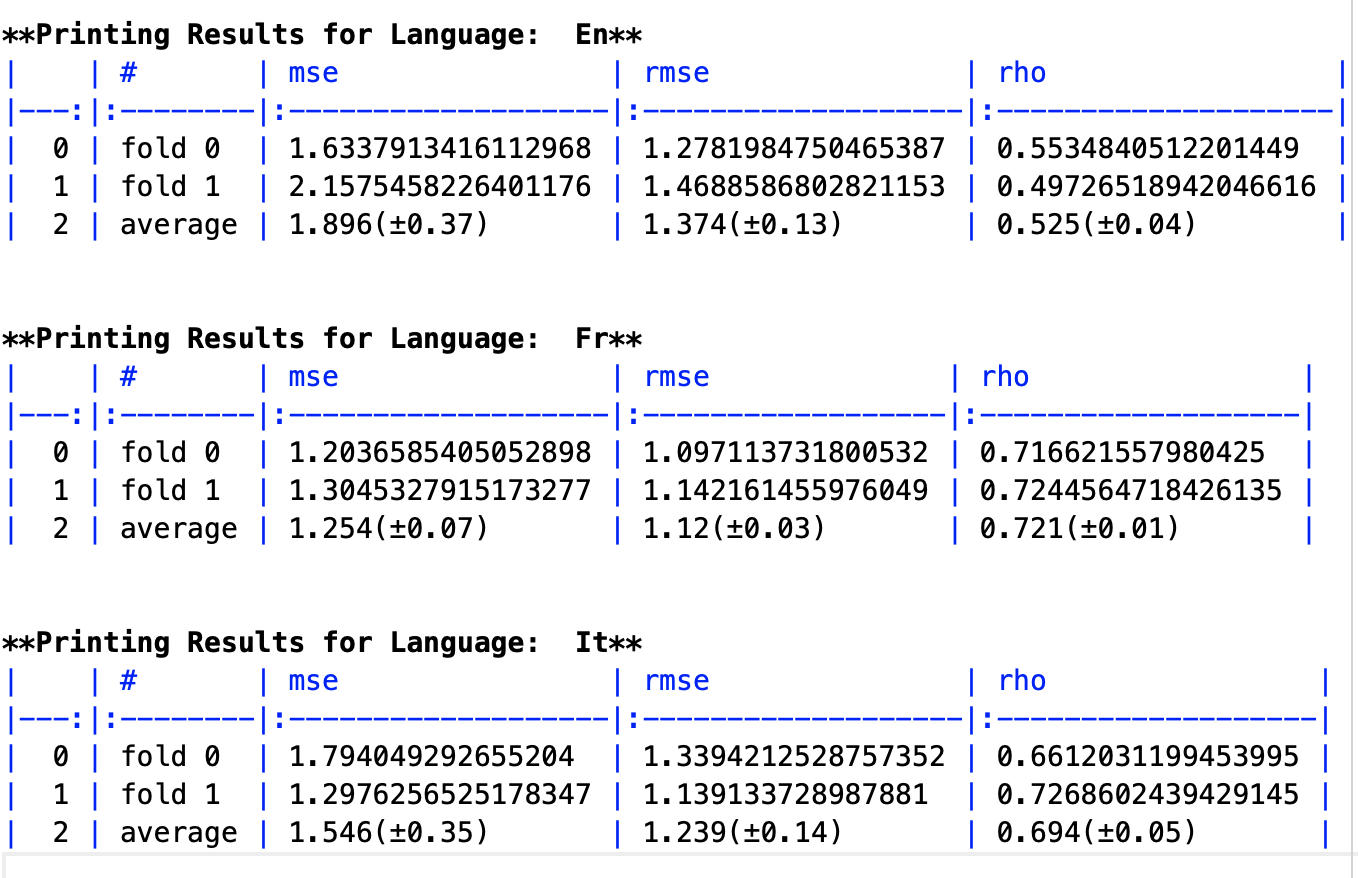

